# Hello, PyTorch

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will teach you to use PyTorch low-level core. If you're running this notebook outside the course environment, you can install it [here](https://pytorch.org).

__PyTorch feels__ differently than Tensorflow on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In PyTorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: PyTorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

And now we finally shut up and let PyTorch do the talking.

In [7]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_%5Brecap%5D_deep_learning/notmnist.py
    !touch .setup_complete

In [145]:
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
%matplotlib inline
print(torch.__version__)

2.6.0+cu124


In [ ]:
# numpy world

x = np.arange(16).reshape(4, 4)

print("X:\n%s\n" % x)
print("X.shape: %s\n" % (x.shape,))
print("add 5:\n%s\n" % (x + 5))
print("X*X^T:\n%s\n" % np.dot(x, x.T))
print("mean over rows:\n%s\n" % (x.mean(axis=-1)))
print("cumsum of cols:\n%s\n" % (np.cumsum(x, axis=0)))

X:
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]

X.shape: (4, 4)

add 5:
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]

X*X^T:
[[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]

mean over rows:
[ 1.5  5.5  9.5 13.5]

cumsum of cols:
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]



In [ ]:
# PyTorch world

x = np.arange(16).reshape(4, 4)

x = torch.tensor(x, dtype=torch.float32)  # or torch.arange(0, 16).view(4, 4)

print("X:\n%s" % x)
print("X.shape: %s\n" % (x.shape,))
print("add 5:\n%s" % (x + 5))
print("X*X^T:\n%s" % torch.matmul(x, x.transpose(1, 0)))  # short: x.mm(x.t())
print("mean over rows:\n%s" % torch.mean(x, dim=-1))
print("cumsum of cols:\n%s" % torch.cumsum(x, dim=0))

X:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
X.shape: torch.Size([4, 4])

add 5:
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T:
tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over rows:
tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


## NumPy and PyTorch

As you can notice, PyTorch allows you to hack stuff much the same way you did with NumPy. No graph declaration, no placeholders, no sessions. This means that you can _see the numeric value of any tensor at any moment of time_. Debugging such code can be done with by printing tensors or using any debug tool you want (e.g. [PyCharm debugger](https://www.jetbrains.com/help/pycharm/part-1-debugging-python-code.html) or [gdb](https://wiki.python.org/moin/DebuggingWithGdb)).

You could also notice the a few new method names and a different API. So no, there's no compatibility with NumPy [yet](https://github.com/pytorch/pytorch/issues/2228) and yes, you'll have to memorize all the names again. Get excited!

![img](http://i0.kym-cdn.com/entries/icons/original/000/017/886/download.jpg)

For example,
* If something takes a list/tuple of axes in NumPy, you can expect it to take `*args` in PyTorch
 * `x.reshape([1,2,8]) -> x.view(1,2,8)`
* You should swap `axis` for `dim` in operations like `mean` or `cumsum`
 * `x.sum(axis=-1) -> x.sum(dim=-1)`
* Most mathematical operations are the same, but types an shaping is different
 * `x.astype('int64') -> x.type(torch.LongTensor)`

To help you acclimatize, there's a [table](https://github.com/torch/torch7/wiki/Torch-for-NumPy-users) covering most new things. There's also a neat [documentation page](http://pytorch.org/docs/master/).

Finally, if you're stuck with a technical problem, we recommend searching [PyTorch forums](https://discuss.pytorch.org/). Or just googling, which usually works just as efficiently.

If you feel like you almost give up, remember two things: __GPU__ and __free gradients__. Besides you can always jump back to NumPy with `x.numpy()`.

### Warmup: trigonometric knotwork
_inspired by [this post](https://www.quora.com/What-are-the-most-interesting-equation-plots)_

There are some simple mathematical functions with cool plots. For one, consider this:

$$ x(t) = t - 1.5 * cos(15 t) $$
$$ y(t) = t - 1.5 * sin(16 t) $$

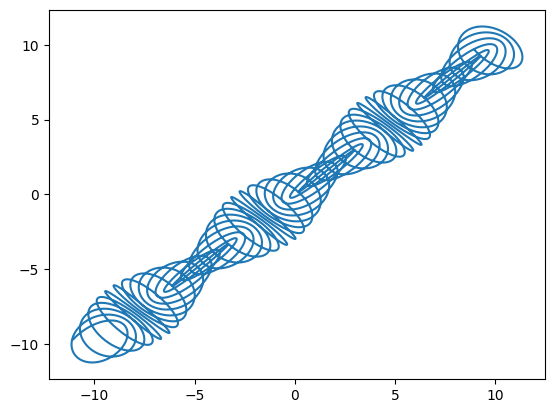

In [ ]:
t = torch.linspace(-10, 10, steps=10000)

# compute x(t) and y(t) as defined above
x = t - 1.5*torch.cos(15*t)
y = t - 1.5*torch.sin(16*t)

plt.plot(x.numpy(), y.numpy())

If you're done early, try adjusting the formula and seeing how it affects the function.

---

## Automatic gradients

Any self-respecting DL framework must do your backprop for you. Torch handles this with the `autograd` module.

The general pipeline looks like this:
* When creating a tensor, you mark it as `requires_grad`:
    * `torch.zeros(5, requires_grad=True)`
    * `torch.tensor(np.arange(5), dtype=torch.float32, requires_grad=True)`
* Define some differentiable `loss = arbitrary_function(a)`
* Call `loss.backward()`
* Gradients are now available as ```a.grad```

__Here's an example:__ let's fit a linear regression on Boston house prices.

In [ ]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing)

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]]), 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]), 'frame': None, 'target_names': ['MedHouseVal'], 'feature_names': ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'], 'DESCR': '.. _california_housing_dataset:\n\nCalifornia Housing dataset\n-

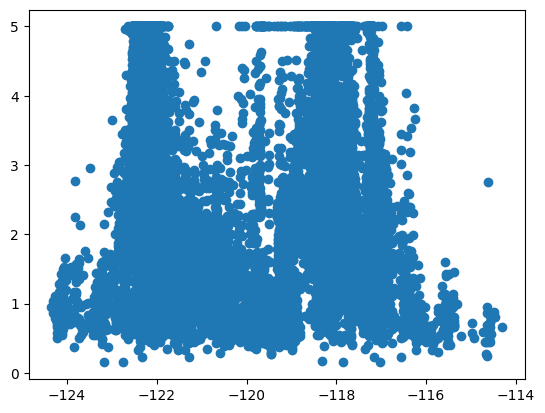

In [ ]:

plt.scatter(housing.data[:, -1], housing.target)

In [ ]:
# w = torch.zeros(1, requires_grad=True)
# b = torch.zeros(1, requires_grad=True)

# x = torch.tensor(boston.data[:, -1] / 10, dtype=torch.float32)
# y = torch.tensor(boston.target, dtype=torch.float32)

In [ ]:
# y_pred = w * x + b
# loss = torch.mean((y_pred - y)**2)

# # propagate gradients
# loss.backward()

The gradients are now stored in `.grad` of those variables that require them.

In [ ]:
# print("dL/dw = \n", w.grad)
# print("dL/db = \n", b.grad)

If you compute gradient from multiple losses, the gradients will add up at variables, therefore it's useful to __zero the gradients__ between iteratons.

In [ ]:
# from IPython.display import clear_output

# for i in range(100):
#     y_pred = w * x + b
#     loss = torch.mean((y_pred - y)**2)
#     loss.backward()

#     w.data -= 0.05 * w.grad.data
#     b.data -= 0.05 * b.grad.data

#     # zero gradients
#     w.grad.data.zero_()
#     b.grad.data.zero_()

#     # the rest of code is just bells and whistles
#     if (i + 1) % 5 == 0:
#         clear_output(True)
#         plt.scatter(x.numpy(), y.numpy())
#         plt.scatter(x.numpy(), y_pred.numpy(), color='orange', linewidth=5)
#         plt.show()

#         print("loss = ", loss.numpy())
#         if loss.numpy() < 0.5:
#             print("Done!")
#             break

__Bonus quest__: try implementing and writing some nonlinear regression. You can try quadratic features or some trigonometry, or a simple neural network. The only difference is that now you have more variables and a more complicated `y_pred`.

# High-level PyTorch

So far we've been dealing with low-level PyTorch API. While it's absolutely vital for any custom losses or layers, building large neural nets in it is a bit clumsy.

Luckily, there's also a high-level PyTorch interface with pre-defined layers, activations and training algorithms.

We'll cover them as we go through a simple image recognition problem: classifying letters into __"A"__ vs __"B"__.


In [ ]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='AB')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

print("Train size = %i, test_size = %i" % (len(X_train), len(X_test)))

Extracting ...
Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done
Train size = 2808, test_size = 937


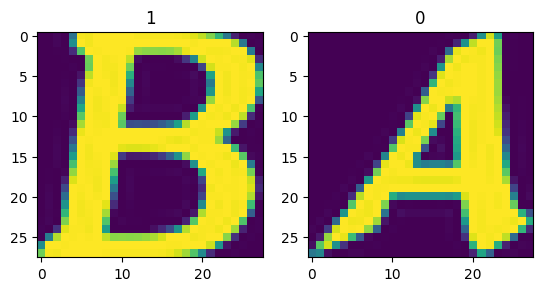

In [ ]:
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

Let's start with layers. The main abstraction here is __`torch.nn.Module`__:

In [ ]:
from torch import nn
import torch.nn.functional as F

print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing them to be nested in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self) -> None:
                super().__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will also have their
    parameters converted when you call :meth:`to`, etc.

    .. note::
        As per the example above, an ``__init__()`` call to the parent class
        must be made before assignment on the child.

    :ivar training: Boolean represents whether this module is in trainin

There's a vast library of popular layers and architectures already built for ya'.

This is a binary classification problem, so we'll train __Logistic Regression__.
$$P(y_i | X_i) = \sigma(W \cdot X_i + b) ={ 1 \over {1+e^{- [W \cdot X_i + b]}} }$$


In [ ]:
# create a network that stacks layers on top of each other
model = nn.Sequential()

# add first "dense" layer with 784 input units and 1 output unit.
model.add_module('l1', nn.Linear(784, 1))

# add softmax activation for probabilities. Normalize over axis 1
# note: layer names must be unique
model.add_module('l2', nn.Sigmoid())

In [ ]:
print("Weight shapes:", [w.shape for w in model.parameters()])

Weight shapes: [torch.Size([1, 784]), torch.Size([1])]


In [ ]:
# create dummy data with 3 samples and 784 features
x = torch.tensor(X_train[:3], dtype=torch.float32)
y = torch.tensor(y_train[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables
y_predicted = model(x)[:, 0]

y_predicted  # display what we've got

tensor([0.4887, 0.3506, 0.3056], grad_fn=<SelectBackward0>)

In [ ]:
print(model(x)[:, 0])

tensor([0.4887, 0.3506, 0.3056], grad_fn=<SelectBackward0>)


In [ ]:
y

tensor([1., 0., 0.])

Let's now define a loss function for our model.

The natural choice is to use binary crossentropy (aka logloss, negative llh):
$$ L = {1 \over N} \underset{X_i,y_i} \sum - [  y_i \cdot log P(y_i=1 | X_i) + (1-y_i) \cdot log (1-P(y_i=1 | X_i)) ]$$



In [ ]:
crossentropy = -(y * torch.log(y_predicted) + (1 - y) * torch.log(1 - y_predicted))
print(crossentropy)

loss = (1 / y.shape[0]) * torch.sum(crossentropy)

assert tuple(crossentropy.size()) == (
    3,), "Crossentropy must be a vector with element per sample"
assert tuple(loss.size()) == tuple(
), "Loss must be scalar. Did you forget the mean/sum?"
assert loss.data.numpy() > 0, "Crossentropy must non-negative, zero only for perfect prediction"
assert loss.data.numpy() <= np.log(
    3), "Loss is too large even for untrained model. Please double-check it."

tensor([0.7159, 0.4317, 0.3648], grad_fn=<NegBackward0>)


In [ ]:
crossentropy = -(y * torch.log(y_predicted) + (1 - y) * torch.log(1 - y_predicted))
print(crossentropy)

loss = F.binary_cross_entropy(y_predicted, y)

assert tuple(crossentropy.size()) == (
    3,), "Crossentropy must be a vector with element per sample"
assert tuple(loss.size()) == tuple(
), "Loss must be scalar. Did you forget the mean/sum?"
assert loss.data.numpy() > 0, "Crossentropy must non-negative, zero only for perfect prediction"
assert loss.data.numpy() <= np.log(
    3), "Loss is too large even for untrained model. Please double-check it."

tensor([0.7159, 0.4317, 0.3648], grad_fn=<NegBackward0>)


__Note:__ you can also find many such functions in `torch.nn.functional`, just type __`F.<tab>`__.

__Torch optimizers__

When we trained Linear Regression above, we had to manually `.zero_()` gradients on both our variables. Imagine that code for a 50-layer network.

Again, to keep it from getting dirty, there's `torch.optim` module with pre-implemented algorithms:

In [ ]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.01)

# here's how it's used:
opt.zero_grad()      # clear gradients
loss.backward()      # add new gradients
opt.step()           # change weights

In [ ]:
# dispose of old variables to avoid bugs later
del x, y, y_predicted, loss

### Putting it all together

In [ ]:
# create network again just in case
model = nn.Sequential()
model.add_module('first', nn.Linear(784, 1))
model.add_module('second', nn.Sigmoid())

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
history = []

for i in range(100):

    # sample 256 random images
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.float32)

    # predict probabilities
    y_predicted = model(x_batch)[:, 0]

    assert y_predicted.dim(
    ) == 1, "did you forget to select first column with [:, 0]"

    # compute loss, just like before
    loss = F.binary_cross_entropy(y_predicted, y_batch)

    # compute gradients
    opt.zero_grad()
    loss.backward()
    opt.step()
    history.append(loss.data.numpy())

    if i % 10 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | mean loss = 0.583
step #10 | mean loss = 0.332
step #20 | mean loss = 0.189
step #30 | mean loss = 0.153
step #40 | mean loss = 0.133
step #50 | mean loss = 0.122
step #60 | mean loss = 0.107
step #70 | mean loss = 0.109
step #80 | mean loss = 0.113
step #90 | mean loss = 0.103


__Debugging tips:__
* Make sure your model predicts probabilities correctly. Just print them and see what's inside.
* Don't forget the _minus_ sign in the loss function! It's a mistake 99% people do at some point.
* Make sure you zero-out gradients after each step. Seriously:)
* In general, PyTorch's error messages are quite helpful, read 'em before you google 'em.
* if you see nan/inf, print what happens at each iteration to find our where exactly it occurs.
  * If loss goes down and then turns nan midway through, try smaller learning rate. (Our current loss formula is unstable).

### Evaluation

Let's see how our model performs on test data

In [ ]:
# use your model to predict classes (0 or 1) for all test samples
predicted_y_test = np.array((model(torch.tensor(X_test, dtype=torch.float32))[:, 0] > 0.5).int())
# print(predicted_y_test)

assert isinstance(predicted_y_test, np.ndarray), "please return np array, not %s" % type(
    predicted_y_test)
assert predicted_y_test.shape == y_test.shape, "please predict one class for each test sample"
assert np.in1d(predicted_y_test, y_test).all(), "please predict class indexes"

accuracy = np.mean(predicted_y_test == y_test)

print("Test accuracy: %.5f" % accuracy)
assert accuracy > 0.95, "try training longer"

Test accuracy: 0.95945


<ipython-input-38-68d6547fde4c>:8: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  assert np.in1d(predicted_y_test, y_test).all(), "please predict class indexes"


## More about PyTorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on PyTorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* PyTorch examples - a repo that implements many cool DL models in PyTorch - [link](https://github.com/pytorch/examples)
* Practical PyTorch - a repo that implements some... other cool DL models... yes, in PyTorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)

---

# Homework tasks

There will be three tasks worth 2, 3 and 5 points respectively.
If you get stuck with no progress, try switching to the next task and returning later.

### Task I (2 points) - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword.


__1.1 The Cannabola__
[(_disclaimer_)](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

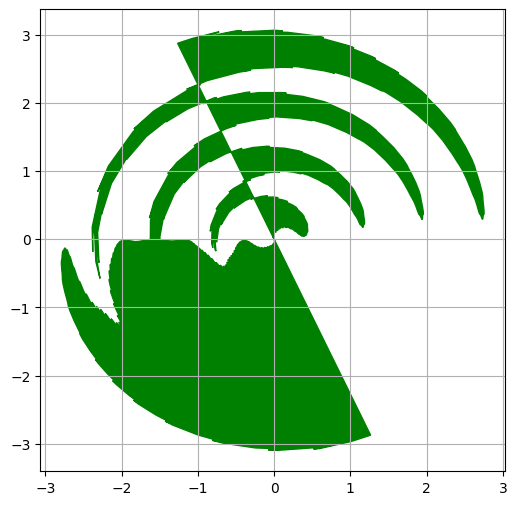

In [48]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(8 * theta)) * (1 + 0.1 * torch.cos(24 * theta)) * (0.9 + 0.05 * torch.cos(200 * theta)) * (1 + torch.sin(theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = torch.cos(rho) * theta
y = torch.sin(rho) * theta


plt.figure(figsize=[6, 6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: The Game of Life (3 points)

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure PyTorch_.

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU!__ Indeed, what could be a better use of your GPU than simulating Game of Life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the URL above out of sloth, here's the Game of Life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference NumPy implementation that you must convert to PyTorch.
_[NumPy code inspired by: https://github.com/rougier/numpy-100]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format.

__Note 2:__ From the mathematical standpoint, PyTorch convolution is actually cross-correlation. Those two are very similar operations. More info: [video tutorial](https://www.youtube.com/watch?v=C3EEy8adxvc), [scipy functions review](http://programmerz.ru/questions/26903/2d-convolution-in-python-similar-to-matlabs-conv2-question), [stack overflow source](https://stackoverflow.com/questions/31139977/comparing-matlabs-conv2-with-scipys-convolve2d).

In [66]:
Z_sample = torch.tensor([[1, 2, 3], [1, 2, 3]])
filter_sample = torch.tensor([[1, 1], [0, 1]])
F.conv2d(Z_sample.reshape((1, 1) + Z_sample.size()), filter_sample.reshape((1, 1, 2, 2)))

tensor([[[[5, 8]]]])

In [49]:
from scipy.signal import correlate2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]])

    N = correlate2d(Z, filters, mode='same')

    # Apply rules
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)

    Z[:] = birth | survive
    return Z

In [77]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.

    You can opt to create a new tensor or change Z inplace.
    """
    filters = torch.tensor([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]]).type(torch.FloatTensor)
    N = F.conv2d(Z.reshape((1, 1) + Z.size()), filters.reshape((1, 1) + filters.size()), padding='same')

    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)

    Z[:] = birth | survive
    return Z

In [79]:
# initial frame
Z_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)
# print(Z)
# your debug polygon :)
Z_new = torch_update(Z.clone())

# tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), \
    "your PyTorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

Well done!


In [80]:
%matplotlib notebook
plt.ion()

# initialize game field
Z = np.random.choice([0, 1], size=(100, 100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    # update
    Z = torch_update(Z)

    # re-draw image
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>

In [81]:
# Some fun setups for your amusement

# parallel stripes
Z = np.arange(100) % 2 + np.zeros([100, 100])
# with a small imperfection
Z[48:52, 50] = 1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

### Task III: Going deeper (5 points)
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>
Your ultimate task for this week is to build your first neural network [almost] from scratch and pure PyTorch.

This time you will solve the same digit recognition problem, but at a larger scale

* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression.

With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train using __categorical crossentropy__  (see [here](http://wiki.fast.ai/index.php/Log_Loss)).  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors.
If you feel confident enough, just start coding right away and get there ~~if~~ once you need to untangle yourself.

In [42]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


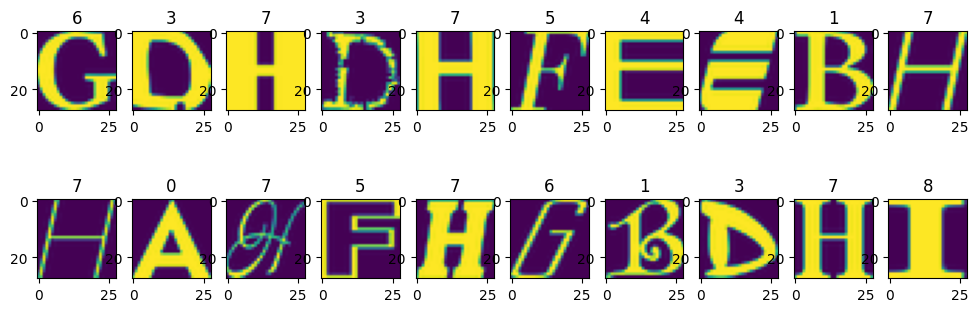

In [44]:
%matplotlib inline
plt.figure(figsize=[12, 4])
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

In [45]:
print(type(X_train))

<class 'numpy.ndarray'>


In [128]:
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))  # share memory with initial numpy array
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [129]:
input_dim = train_dataset[0][0].shape[0]
output_dim = torch.max(train_dataset[:][1]).item() + 1
print(input_dim, output_dim)

784 10


In [143]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # share memory with initial numpy array
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)  # share memory with initial numpy array

In [131]:
print(train_loader.dataset[0][0][:4], train_loader.dataset[0][1])
print(len(train_loader.dataset))

tensor([-0.9275, -0.9275, -0.9275, -0.9275]) tensor(9)
4681


In [132]:
tensor = torch.tensor([[3, 2], [0, 1]]).type(torch.float)
sm = nn.Softmax(dim=0)
# dim=1  <-- by each row

print(sm(tensor))

tensor([[0.9526, 0.7311],
        [0.0474, 0.2689]])


In [133]:
print(tensor.argmax(dim=1))

tensor([0, 1])


In [194]:
for x, y in train_loader:
    print(x)
    print(y.shape[0])
    break

tensor([[ 0.6373,  1.2530,  1.2530,  ...,  1.2530,  1.2530,  0.4064],
        [ 1.2530,  1.2530,  1.2530,  ...,  1.2530,  1.2530,  1.2530],
        [ 0.2953,  0.9622,  1.2530,  ..., -0.9275, -0.9275, -0.9275],
        ...,
        [-0.9275, -0.9275, -0.9275,  ..., -0.9275, -0.9275, -0.9275],
        [-0.9275, -0.9275, -0.9275,  ..., -0.9275, -0.9275, -0.9275],
        [-0.9275, -0.6881,  1.2530,  ..., -0.9275, -0.9275, -0.9275]])
64


In [289]:
class Model(nn.Module):  # We HAVE to transfer this model to device after initialization
    def __init__(self, input_dim, output_dim):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, 80))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(80, 40))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(40, 20))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(20, output_dim))
        # layers.append(nn.Softmax(dim=1))  # Is inside nn.CrossEntropyLoss()
        # dim=1  <-- by each row

        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

In [290]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    loss_sum, correct_sum = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x.shape[0]
        correct_sum += (out.argmax(dim=1) == y).sum().item()
    n = len(loader.dataset)
    return loss_sum / n, correct_sum / n

In [291]:
def eval_epoch(model, loader, criterion, device):
    model.train()  # switch ceratin layers - like Dropout and BatchNorm - into inference mode
    loss_sum, correct_sum = 0, 0
    with torch.no_grad():  # tells PyTorch to stop tracking operations for gradient computation
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            loss_sum += loss.item() * x.shape[0]
            correct_sum += (out.argmax(dim=1) == y).sum().item()
            # print((out.argmax(dim=1) == y).sum().item())
    n = len(loader.dataset)
    return loss_sum / n, correct_sum / n

In [292]:
def show_progress(epoch, train_losses, val_losses, train_accs, val_accs):
    clear_output(wait=True)
    print(f"Epoch {epoch}: train_loss={train_losses[-1]:.4f}, train_acc={train_accs[-1]:.4f}, "
          f"val_loss={val_losses[-1]:.4f}, val_acc={val_accs[-1]:.4f}")

    plt.figure(figsize=[10,4])
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

In [293]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
epochs = 10
learning_rate = 1e-3

cpu


In [294]:
model = Model(input_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [295]:
print(model(train_dataset[:4][0]))

tensor([[-0.0298, -0.2493,  0.1579,  0.0148, -0.0852, -0.2843, -0.2059, -0.0016,
         -0.1819, -0.0215],
        [-0.0378, -0.2038,  0.1787,  0.0079, -0.0828, -0.2999, -0.1910, -0.0045,
         -0.1685,  0.0021],
        [-0.0501, -0.2213,  0.2131, -0.0111, -0.0856, -0.2891, -0.2216,  0.0007,
         -0.1638, -0.0039],
        [-0.0290, -0.2446,  0.1635,  0.0123, -0.0639, -0.2995, -0.1978, -0.0210,
         -0.1595, -0.0149]], grad_fn=<AddmmBackward0>)


Epoch 10: train_loss=0.0991, train_acc=0.9697, val_loss=0.4019, val_acc=0.9122


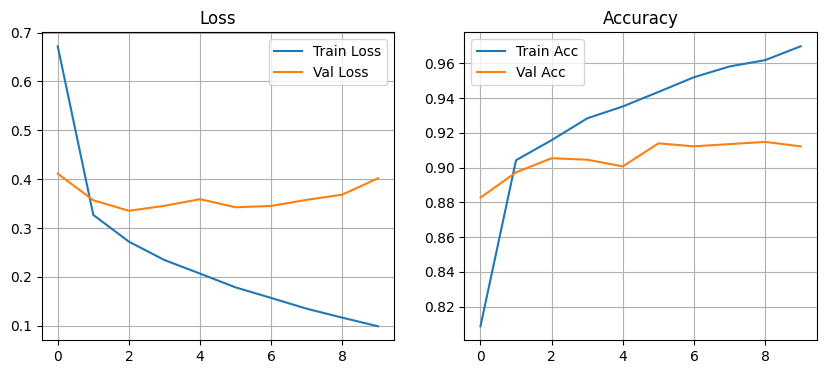

In [296]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, epochs+1):
    tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    vl_loss, vl_acc = eval_epoch(model, test_loader, criterion, device)
    train_losses.append(tr_loss)
    val_losses.append(vl_loss)
    train_accs.append(tr_acc)
    val_accs.append(vl_acc)

    # print(train_losses, val_losses, train_accs, val_accs)
    # Display progress
    show_progress(epoch, train_losses, val_losses, train_accs, val_accs)

# plt.close('all')

<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>

# SPOILERS!

Recommended pipeline:

* Adapt logistic regression from previous assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - Softmax (exp over sum of exps) can be implemented manually or as `nn.Softmax` (layer) or `F.softmax` (function)
  - Probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - You can also try momentum/rmsprop/adawhatever
    - in which case the dataset should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just the output layer :)
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
  - In ideal case this totals to 2 `torch.matmul`'s, 1 softmax and 1 ReLU/sigmoid
  - __Make sure this neural network works better than logistic regression!__

* Now's the time to try improving the network. Consider layers (size, neuron count), nonlinearities, optimization methods, initialization — whatever you want, but please avoid convolutions for now.

* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate $\log P(y \mid x)$ as `F.log_softmax(layer_before_softmax)`.